## 四、Softmax从零开始实现

In [1]:
import torch
from d2l import torch as d2l

#### 4.1 数据读取

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

100.0%


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.0%

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



#### 4.2 数据处理

对于softmax模型，输入是一个向量，输出维度是每一个类别的数量
- 展开图像，拉长为一个向量（损失了空间信息）
- 数据集有10个类别，输出维度为10

In [4]:
num_inputs = 28 * 28
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

#### 4.3 网络定义

##### softmax操作子
softmax对于矩阵**X**中的每一行进行作用，使得每一行的和为1，元素非负

In [5]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  #广播机制

In [6]:
# 测试
X = torch.normal(0, 1, (2, 5))
print(torch.exp(X).sum(1, keepdim=True))
# 维度为1，按行求和，keepdim不降维

tensor([[5.4844],
        [4.9903]])


In [8]:
# 测试
X_prob = softmax(X)
print(X_prob, X_prob.sum(1))  #经过softmax，每一行的和都变成1

tensor([[0.1531, 0.2601, 0.1711, 0.1903, 0.2255],
        [0.0607, 0.6507, 0.0380, 0.1142, 0.1363]]) tensor([1.0000, 1.0000])


##### softmax网络模型
将计算完成后的结果通过softmax使得和为1

In [9]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

#### 4.3 损失评估与优化

##### 交叉熵损失函数（计算损失）

**补充：根据实际下标取出预测分类的概率值**

1. `y` 是一个一维张量，包含了每个图像的实际类别标签，这里是 `[0, 2]`。这意味着第一个图像的真实类别是 0 类，第二个图像的真实类别是 2 类。

2. `y_hat` 是一个二维张量，每一行代表一个图像的预测结果，包括每个类别的概率。这里，`y_hat` 的第一行 `[0.1, 0.3, 0.6]` 表示第一个图像的每个类别（0, 1, 2）的预测概率，第二行 `[0.3, 0.2, 0.5]` 表示第二个图像的每个类别的预测概率。

3. 当使用 `y_hat[[0,1],y]` 这种索引方式时，PyTorch 会根据 `y` 中的元素作为列索引，`[0,1]` 作为行索引。具体来说：
   - 对于第一个图像（行索引 0），类别索引是 `y[0]`，即 0，所以选择了 `y_hat[0, 0]`，值为 0.1。
   - 对于第二个图像（行索引 1），类别索引是 `y[1]`，即 2，所以选择了 `y_hat[1, 2]`，值为 0.5。

所以，`y_hat[[0,1],y]` 最终的结果是一个张量，包含了每个图像对应其真实类别的预测概率。在这个例子中，结果将是一个张量 `[0.1, 0.5]`。

这种索引技巧非常有用，特别是在处理分类任务的神经网络预测输出时，可以直接根据实际的标签索引来获取预测的概率。这通常用于计算损失函数，例如交叉熵损失，其中需要比较实际类别和预测概率。

In [14]:
y = torch.tensor([0, 2])  #两个图片的真实结果
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])  # 预测结果
y_hat[[0, 1], y]  #取出结果

tensor([0.1000, 0.5000])

实现

In [15]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

In [16]:
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

##### 预测类与真实类的比较（预测对的个数）

In [19]:
def accuracy(y_hat, y):
    """预测正确的样本数"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [20]:
accuracy(y_hat, y) / len(y)

0.5

##### 模型准确率的评估（任意模型）

In [21]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [22]:
def evaluate_accuracy(net, data_iter):
    """计算指定数据集上的模型精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  #不累计梯度，设置为评估模式
    metric = Accumulator(2)  #正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

##### 优化函数

In [25]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W,b], lr, batch_size)

#### 4.4训练模型

##### 训练一个epoch

In [23]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3) # 准确度、正确数量、总数量
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

##### 训练整个模型并输出

In [24]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = d2l.Animator(xlabel='epoch', 
                            xlim=[1, num_epochs], 
                            ylim=[0.3, 0.9], 
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc,))
    train_loss, train_acc = train_metrics

##### 开始训练

In [27]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

#### 4.5分类预测

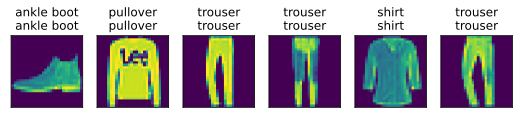

In [28]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)